In [1]:
#generate demographics tables

Setting BASE_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data/
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments/co-ripa1


In [ ]:
import pandas as pd
import numpy as np
import os
#import meld_classifier.old_hdf5_io as hio
import matplotlib.pyplot as plt
import meld_classifier.paths as paths
from statsmodels.stats.proportion import proportion_confint
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from statsmodels.stats.multitest import multipletests
from meld_classifier.meld_cohort import MeldCohort, MeldSubject
import meld_classifier.paths as p

In [13]:
path = '/rds/project/kw350/rds-kw350-meld'

In [16]:
demographics_file = os.path.join(path,'meld_data/Data/demographics_qc_allgroups.csv')
included_subs_file = os.path.join(path,'meld_data/Data/overview_cohort_6.csv')


In [17]:
demographics = pd.read_csv(demographics_file,index_col=False)
included_subs = pd.read_csv(included_subs_file,index_col=False)


In [19]:
vec_exclude = np.array(included_subs)[:,-3:-1].any(axis=1).astype(bool)
excluded = included_subs[vec_exclude]
demographics=demographics[~vec_exclude]

In [20]:
#total patients prior to any exclusion
print(np.sum(included_subs.group=='patient'),np.sum(included_subs.group=='control'))
# total excluded:
print(np.sum(excluded.group=='patient'),np.sum(excluded.group=='control'))
#QC
print(np.sum(included_subs['excluded_because_outlier']-included_subs['excluded_because_nolesion']>0))
# no lesion mask
print(np.sum(included_subs['excluded_because_nolesion']))
#total remaining patients
print(np.sum(demographics.group=='patient'),np.sum(demographics.group=='control'))
print(np.nanmedian(demographics['Age at preoperative'][demographics.group=='patient']),
                  np.nanpercentile(demographics['Age at preoperative'][demographics.group=='patient'],25),
                   np.nanpercentile(demographics['Age at preoperative'][demographics.group=='patient'],75))
print(np.sum(demographics['Sex'][demographics.group=='patient']==0),
      np.sum(demographics['Sex'][demographics.group=='patient']))

print(np.nanmedian(demographics['Age at preoperative'][demographics.group=='control']),
                  np.nanpercentile(demographics['Age at preoperative'][demographics.group=='control'],25),
                   np.nanpercentile(demographics['Age at preoperative'][demographics.group=='control'],75))
print(np.sum(demographics['Sex'][demographics.group=='control']==0),
      np.sum(demographics['Sex'][demographics.group=='control']))


618 397
45 5
13
37
573 392
17.6 10.0 30.0
289 283.0
28.6 17.3 37.5
219 172.0


In [21]:
#numbers excluded:
#total patients prior to any exclusion 618
# breakdown of why excluded 50
# QC or not having lesion mask (default is QC)
#of those that table over whole cohort and split.


In [22]:
folder  = '/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/iteration_21-09-15/ensemble_21-09-15/fold_all/results/'
res_file = os.path.join(folder,'test_results.csv')
test_df=pd.read_csv(res_file,index_col=False)
test_df.drop_duplicates(inplace=True,ignore_index=True)
test_df.groupby('group').mean()
fp = test_df['n_clusters']<1
test_df['any']=fp
test_df.border=test_df.border>100
test_df.detected+=test_df.border
test_df=test_df.dropna()
test_df.detected=test_df.detected.astype(int)

/rds/user/co-ripa1/hpc-work/envs/env_pyt3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [23]:
folder  = '/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/iteration_21-09-17/ensemble_21-09-20/fold_all/results/'
res_file = os.path.join(folder,'test_results.csv')
n = pd.read_csv(res_file,index_col=False)
n.drop_duplicates(inplace=True,ignore_index=True)
n.dropna(inplace=True)

fp = n['n_clusters']<1
n['any']=fp
n.border=n.border>100
n.detected+=n.border
n=n.dropna()

/rds/user/co-ripa1/hpc-work/envs/env_pyt3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [24]:
# for DI in test_df[np.logical_and(test_df.detected==1,test_df.n_clusters==1.0)].ID:
#     if demographics.Lobe[demographics.ID==DI].values=='temporal':
#         print(DI,demographics.Lobe[demographics.ID==DI])

In [25]:
subsets = np.zeros((len(demographics),4),dtype=bool)

group = np.ones(len(demographics),dtype=bool)
sites = np.zeros(len(demographics),dtype=object)
for i,d in enumerate(demographics.ID):
        if d in n.ID.values:
            subsets[i,0]=True
        if d in test_df.ID.values:
            subsets[i,1] = True
        if '_C_' in d:
            group[i] = False
        if 'H27' in d:
            subsets[i,2] = True
        if 'H28' in d:
            subsets[i,3] = True
        sites[i]=d.split('_')[1]

In [26]:
demographics

,ID,Site,group,Age of onset,Duration,Age at preoperative,Sex,Ever reported MRI negative,Engel Outcome,Histology,Surgery,f/u,FreeSurfer,Scanner,lesion,Hemisphere,Lobe,FLAIR,Seizure free
0,MELD_H2_15T_FCD_0001,H2,patient,15.000000,5.000000,20.000000,1.0,0.0,1.0,NaN,1.0,5.00,5.3,15T,True,lh,temporal,False,1.0
1,MELD_H2_15T_FCD_0002,H2,patient,6.000000,3.000000,9.000000,0.0,0.0,1.0,NaN,1.0,1.00,5.3,15T,True,lh,frontal,False,1.0
2,MELD_H2_15T_FCD_0003,H2,patient,0.900000,9.100000,10.000000,0.0,0.0,NaN,NaN,0.0,NaN,5.3,15T,True,rh,temporal,False,NaN
3,MELD_H2_15T_FCD_0005,H2,patient,7.000000,13.000000,20.000000,1.0,0.0,NaN,NaN,0.0,NaN,5.3,15T,True,lh,temporal,False,NaN
4,MELD_H2_15T_FCD_0006,H2,patient,12.000000,7.000000,19.000000,0.0,0.0,NaN,NaN,0.0,NaN,5.3,15T,True,rh,frontal,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,MELD_H28_3T_FCD_0019,H28,patient,3.000000,0.400000,3.400000,0.0,0.0,1.0,FCD_2B,1.0,3.40,5.3,3T,True,rh,parietal,True,1.0
1011,MELD_H28_3T_FCD_0020,H28,patient,2.000000,1.167123,3.167123,1.0,0.0,1.0,FCD_3,1.0,3.00,5.3,3T,True,rh,parietal,True,1.0
1012,MELD_H28_3T_FCD_0022,H28,patient,0.916667,1.206621,2.123288,1.0,0.0,1.0,FCD_2B,1.0,0.75,5.3,3T,True,rh,parietal,True,1.0
1013,MELD_H28_3T_FCD_0023,H28,patient,2.000000,1.786301,3.786301,1.0,0.0,1.0,FCD_2B,1.0,4.80,5.3,3T,True,rh,parietal,True,1.0


In [27]:
demographics['group'] = group
demographics['Site'] = sites

In [28]:
rows=['Age of onset','Duration', 'Age at preoperative', 'Sex',
       'Ever reported MRI negative','Lesion area','Hemisphere','Surgery','Seizure free',
      'FLAIR','Scanner']

In [35]:
#trainpat
train = demographics[subsets[:,0]]
train_pat = train[train.group]
h=np.zeros(len(train_pat))
for f, fi in enumerate(train_pat['Histology'].values):
    if isinstance(fi,str):
        h[f] = 1
n_s=np.sum(train_pat['Seizure free']==0)+np.sum(train_pat['Seizure free']==1)
#traincont
train_cont = train[~train.group]

#testpat
test = demographics[subsets[:,1]]
test_pat = test[test.group]
ht=np.zeros(len(test_pat))
for f, fi in enumerate(test_pat['Histology'].values):
    if isinstance(fi,str):
        ht[f] = 1
n_st=np.sum(test_pat['Seizure free']==0)+np.sum(test_pat['Seizure free']==1)
test_cont = test[~test.group]

new = demographics[subsets[:,2]]
new_pat = new[new.group]
htn=np.zeros(len(new_pat))
for f, fi in enumerate(new_pat['Histology'].values):
    if isinstance(fi,str):
        htn[f] = 1
n_stn=np.sum(new_pat['Seizure free']==0)+np.sum(new_pat['Seizure free']==1)
#test_cont = test[~test.group]
new_cont = new[~new.group]

new2 = demographics[subsets[:,3]]
new_pat2 = new2[new2.group]
htn2=np.zeros(len(new_pat2))
for f, fi in enumerate(new_pat2['Histology'].values):
    if isinstance(fi,str):
        htn2[f] = 1
n_stn2=np.sum(new_pat2['Seizure free']==0)+np.sum(new_pat2['Seizure free']==1)
#test_cont = test[~test.group]
new_cont = new[~new.group]

data = {'':  ['Age at preoperative scan (median,IQR)',
             'Sex (f:m)',
             'Age of epilepsy onset (median,IQR)',
             'Duration of epilepsy (median,IQR)',
             'Surgery',
             'Histology',
             'Seizure free','Follow up time', 
             'FLAIR available','Scanner (1.5T:3T)'],
        'Train cohort Patients (n= {})'.format(train_pat.group.sum()):['{} , ({} - {})'.format(np.round(train_pat.median()['Age at preoperative'],1),
                                                             np.round(np.nanpercentile(train_pat['Age at preoperative'],25),1),
                                                             np.round(np.nanpercentile(train_pat['Age at preoperative'],75),1)),
                                                 '{} : {}'.format((train_pat.Sex==0).sum(), (train_pat.Sex==1).sum()),
                                                '{} , ({} - {})'.format(np.round(train_pat.median()['Age of onset'],1),
                                                                        np.round(np.nanpercentile(train_pat['Age of onset'],25),1),
                                                             np.round(np.nanpercentile(train_pat['Age of onset'],75),1)),
                                                '{} , ({} - {})'.format(np.round(train_pat.median()['Duration'],1),
                                                                        np.round(np.nanpercentile(train_pat['Duration'],25),1),
                                                             np.round(np.nanpercentile(train_pat['Duration'],75),1)),
                                                '{} / {} ({}%)'.format(int(train_pat.Surgery.sum()), int(len(train_pat)),
                                                                       round(100*(train_pat.Surgery.sum()/len(train_pat)),0)),
                                                '{} / {} ({}%)'.format(int(h.sum()),int(train_pat.Surgery.sum()),
                                                                       round(100*(h.sum()/train_pat.Surgery.sum()),0)),
                                                '{} / {} ({}%)'.format((train_pat['Seizure free']==1).sum(),n_s,
                                                                       round(100*((train_pat['Seizure free']==1).sum()/n_s),0)),
                                                '{} , ({} - {})'.format(np.round(train_pat.median()['f/u'],1),
                                                                        np.round(np.nanpercentile(train_pat['f/u'],25),1),
                                                             np.round(np.nanpercentile(train_pat['f/u'],75),1)),
                                                '{} / {} ({}%)'.format((train_pat['FLAIR']==True).sum(),int(len(train_pat)),
                                                                       round(100*((train_pat['FLAIR']==1).sum()/int(len(train_pat))),0)),
                                                '{} : {}'.format((train_pat.Scanner=='15T').sum(), (train_pat.Scanner=='3T').sum()),],
        'Train cohort Controls (n= {})'.format(len(train_cont)):['{} , ({} - {})'.format(np.round(train_cont.median()['Age at preoperative'],1),
                                                             np.round(np.nanpercentile(train_cont['Age at preoperative'],25),1),
                                                             np.round(np.nanpercentile(train_cont['Age at preoperative'],75),1)),
                                                 '{} : {}'.format((train_cont.Sex==0).sum(), (train_cont.Sex==1).sum()),
                                                '','','','','','',
                                                '{} / {} ({}%)'.format((train_cont['FLAIR']==True).sum(),int(len(train_cont)),
                                                                       round(100*((train_cont['FLAIR']==1).sum()/int(len(train_cont))),0)),
                                                '{} : {}'.format((train_cont.Scanner=='15T').sum(), (train_cont.Scanner=='3T').sum()),],
        'Test cohort Patients (n= {})'.format(test_pat.group.sum()):['{} , ({} - {})'.format(np.round(test_pat.median()['Age at preoperative'],1),
                                                             np.round(np.nanpercentile(test_pat['Age at preoperative'],25),1),
                                                             np.round(np.nanpercentile(test_pat['Age at preoperative'],75),1)),
                                                 '{} : {}'.format((test_pat.Sex==0).sum(), (test_pat.Sex==1).sum()),
                                                '{} , ({} - {})'.format(np.round(test_pat.median()['Age of onset'],1),
                                                                        np.round(np.nanpercentile(test_pat['Age of onset'],25),1),
                                                             np.round(np.nanpercentile(test_pat['Age of onset'],75),1)),
                                                '{} , ({} - {})'.format(np.round(test_pat.median()['Duration'],2),
                                                                        np.round(np.nanpercentile(test_pat['Duration'],25),1),
                                                             np.round(np.nanpercentile(test_pat['Duration'],75),1)),
                                                '{} / {} ({}%)'.format(int(test_pat.Surgery.sum()), int(len(test_pat)),
                                                                       round(100*(test_pat.Surgery.sum()/len(test_pat)),0)),
                                                '{} / {} ({}%)'.format(int(ht.sum()),int(test_pat.Surgery.sum()),
                                                                       round(100*(ht.sum()/test_pat.Surgery.sum()),0)),
                                                '{} / {} ({}%)'.format((test_pat['Seizure free']==1).sum(),n_st,
                                                                       round(100*((test_pat['Seizure free']==1).sum()/n_st),0)),
                                                '{} , ({} - {})'.format(np.round(test_pat.median()['f/u'],1),
                                                                        np.round(np.nanpercentile(test_pat['f/u'],25),1),
                                                             np.round(np.nanpercentile(test_pat['f/u'],75),1)), 
                                                '{} / {} ({}%)'.format((test_pat['FLAIR']==True).sum(),int(len(test_pat)),
                                                                       round(100*((test_pat['FLAIR']==1).sum()/int(len(test_pat))),0)),
                                                 '{} : {}'.format((test_pat.Scanner=='15T').sum(), (test_pat.Scanner=='3T').sum()),],
        'Test cohort Controls (n= {})'.format(len(test_cont)):['{} , ({} - {})'.format(np.round(test_cont.median()['Age at preoperative'],1),
                                                             np.round(np.nanpercentile(test_cont['Age at preoperative'],25),1),
                                                             np.round(np.nanpercentile(test_cont['Age at preoperative'],75),1)),
                                                 '{} : {}'.format((test_cont.Sex==0).sum(), (test_cont.Sex==1).sum()),
                                                '','','','','','',
                                                '{} / {} ({}%)'.format((test_cont['FLAIR']==True).sum(),int(len(test_cont)),
                                                                       round(100*((test_cont['FLAIR']==1).sum()/int(len(test_cont))),0)),
                                                 '{} : {}'.format((test_cont.Scanner=='15T').sum(), (test_cont.Scanner=='3T').sum()),],
        
        'Independent test site 1 Patients (n= {})'.format(new_pat.group.sum()):['{} , ({} - {})'.format(np.round(new_pat.median()['Age at preoperative'],1),
                                                             np.round(np.nanpercentile(new_pat['Age at preoperative'],25),1),
                                                             np.round(np.nanpercentile(new_pat['Age at preoperative'],75),1)),
                                                 '{} : {}'.format((new_pat.Sex==0).sum(), (new_pat.Sex==1).sum()),
                                                '{} , ({} - {})'.format(np.round(new_pat.median()['Age of onset'],1),
                                                                        np.round(np.nanpercentile(new_pat['Age of onset'],25),1),
                                                             np.round(np.nanpercentile(new_pat['Age of onset'],75),1)),
                                                '{} , ({} - {})'.format(np.round(new_pat.median()['Duration'],2),
                                                                        np.round(np.nanpercentile(new_pat['Duration'],25),1),
                                                             np.round(np.nanpercentile(new_pat['Duration'],75),1)),
                                                '{} / {} ({}%)'.format(int(new_pat.Surgery.sum()), int(len(new_pat)),
                                                                       round(100*(new_pat.Surgery.sum()/len(new_pat)),0)),
                                                '{} / {} ({}%)'.format(int(htn.sum()),int(new_pat.Surgery.sum()),
                                                                       round(100*(htn.sum()/new_pat.Surgery.sum()),0)),
                                                '{} / {} ({}%)'.format((new_pat['Seizure free']==1).sum(),n_stn,
                                                                       round(100*((new_pat['Seizure free']==1).sum()/n_stn),0)),
                                                '{} , ({} - {})'.format(np.round(new_pat.median()['f/u'],1),
                                                                        np.round(np.nanpercentile(new_pat['f/u'],25),1),
                                                             np.round(np.nanpercentile(new_pat['f/u'],75),1)), 
                                                '{} / {} ({}%)'.format((new_pat['FLAIR']==True).sum(),int(len(new_pat)),
                                                                       round(100*((new_pat['FLAIR']==1).sum()/int(len(new_pat))),0)),
                                                '{} : {}'.format((new_pat.Scanner=='15T').sum(), (new_pat.Scanner=='3T').sum()),],
        'Independent test site 1 Controls (n= {})'.format(len(new_cont)):['{} , ({} - {})'.format(np.round(new_cont.median()['Age at preoperative'],1),
                                                             np.round(np.nanpercentile(new_cont['Age at preoperative'],25),1),
                                                             np.round(np.nanpercentile(new_cont['Age at preoperative'],75),1)),
                                                 '{} : {}'.format((new_cont.Sex==0).sum(), (new_cont.Sex==1).sum()),
                                                '','','','','','',
                                                '{} / {} ({}%)'.format((new_cont['FLAIR']==True).sum(),int(len(new_cont)),
                                                                       round(100*((new_cont['FLAIR']==1).sum()/int(len(new_cont))),0)),
                                                '{} : {}'.format((new_pat.Scanner=='15T').sum(), (new_pat.Scanner=='3T').sum()),],
        'Independent test site 2 Patients (n= {})'.format(new_pat2.group.sum()):['{} , ({} - {})'.format(np.round(new_pat2.median()['Age at preoperative'],1),
                                                             np.round(np.nanpercentile(new_pat2['Age at preoperative'],25),1),
                                                             np.round(np.nanpercentile(new_pat2['Age at preoperative'],75),1)),
                                                 '{} : {}'.format((new_pat2.Sex==0).sum(), (new_pat2.Sex==1).sum()),
                                                '{} , ({} - {})'.format(np.round(new_pat2.median()['Age of onset'],1),
                                                                        np.round(np.nanpercentile(new_pat2['Age of onset'],25),1),
                                                             np.round(np.nanpercentile(new_pat2['Age of onset'],75),1)),
                                                '{} , ({} - {})'.format(np.round(new_pat2.median()['Duration'],2),
                                                                        np.round(np.nanpercentile(new_pat2['Duration'],25),1),
                                                             np.round(np.nanpercentile(new_pat2['Duration'],75),1)),
                                                '{} / {} ({}%)'.format(int(new_pat2.Surgery.sum()), int(len(new_pat2)),
                                                                       round(100*(new_pat2.Surgery.sum()/len(new_pat2)),0)),
                                                '{} / {} ({}%)'.format(int(htn2.sum()),int(new_pat2.Surgery.sum()),
                                                                       round(100*(htn2.sum()/new_pat2.Surgery.sum()),0)),
                                                '{} / {} ({}%)'.format((new_pat2['Seizure free']==1).sum(),n_stn2,
                                                                       round(100*((new_pat2['Seizure free']==1).sum()/n_stn2),0)),
                                                '{} , ({} - {})'.format(np.round(new_pat2.median()['f/u'],1),
                                                                        np.round(np.nanpercentile(new_pat2['f/u'],25),1),
                                                             np.round(np.nanpercentile(new_pat2['f/u'],75),1)),
                                                '{} / {} ({}%)'.format((new_pat2['FLAIR']==True).sum(),int(len(new_pat2)),
                                                                       round(100*((new_pat2['FLAIR']==1).sum()/int(len(new_pat2))),0)),
                                                '{} : {}'.format((new_pat2.Scanner=='15T').sum(), (new_pat2.Scanner=='3T').sum()),],
        }
df = pd.DataFrame (data)
df

/rds/user/co-ripa1/hpc-work/envs/env_pyt3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/rds/user/co-ripa1/hpc-work/envs/env_pyt3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/rds/user/co-ripa1/hpc-work/envs/env_pyt3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


,,Train cohort Patients (n= 278),Train cohort Controls (n= 180),Test cohort Patients (n= 260),Test cohort Controls (n= 193),Independent test site 1 Patients (n= 17),Independent test site 1 Controls (n= 18),Independent test site 2 Patients (n= 16)
0,"Age at preoperative scan (median,IQR)","20.0 , (11.0 - 32.8)","29.0 , (19.0 - 37.9)","18.0 , (11.0 - 29.0)","29.0 , (19.5 - 39.2)","7.3 , (5.2 - 11.1)","14.6 , (10.5 - 16.1)","6.1 , (3.4 - 16.2)"
1,Sex (f:m),150 : 127,105 : 75,125 : 135,104 : 88,7 : 10,10 : 8,6 : 10
2,"Age of epilepsy onset (median,IQR)","6.0 , (2.5 - 12.0)",,"6.0 , (3.0 - 11.0)",,"3.4 , (0.8 - 5.8)",,"2.0 , (0.9 - 5.1)"
3,"Duration of epilepsy (median,IQR)","10.0 , (4.3 - 18.4)",,"10.2 , (5.0 - 18.2)",,"3.0 , (0.5 - 7.2)",,"2.4 , (1.3 - 8.1)"
4,Surgery,208 / 278 (75.0%),,190 / 260 (73.0%),,5 / 17 (29.0%),,16 / 16 (100.0%)
5,Histology,193 / 208 (93.0%),,171 / 190 (90.0%),,4 / 5 (80.0%),,16 / 16 (100.0%)
6,Seizure free,123 / 183 (67.0%),,106 / 157 (68.0%),,3 / 5 (60.0%),,14 / 16 (88.0%)
7,Follow up time,"2.0 , (1.0 - 3.0)",,"2.0 , (1.0 - 3.4)",,"1.5 , (1.1 - 1.7)",,"2.9 , (1.9 - 4.4)"
8,FLAIR available,132 / 278 (47.0%),28 / 180 (16.0%),110 / 260 (42.0%),28 / 193 (15.0%),17 / 17 (100.0%),18 / 18 (100.0%),16 / 16 (100.0%)
9,Scanner (1.5T:3T),41 : 237,18 : 162,56 : 204,15 : 178,0 : 17,0 : 17,0 : 16


In [47]:
df.to_excel("demographics_final_table.xlsx",)  

In [69]:
# number of operated patients with available histology
(193+171+4+16)/(278+260+17+16)*100

67.25043782837128

In [ ]:
#make dot plot for cohorts

df=train.sort_values(['Site','group']).copy()
s,c=np.unique(df.Site,return_counts=True)


In [102]:
square_size = np.ceil(np.sqrt(len(df)))


In [103]:
import seaborn as sns
colors=sns.color_palette('tab20')
#colors.extend([(1,1,1)])
np.random.shuffle(colors)

In [107]:
sites.index

[(0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.968627450

In [108]:
sites = list(np.unique(demographics.Site))
sites.remove('H27')
sites.remove("H28")

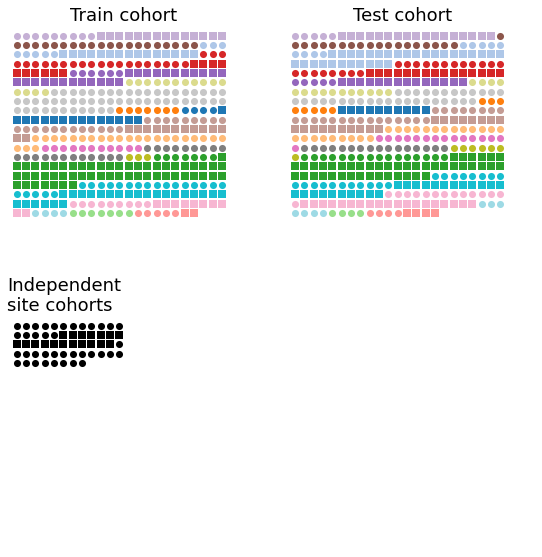

In [113]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})

fig,axes = plt.subplots(2,2,figsize=(8,8))
axes=axes.ravel()
k=-1

df=train.copy()
df.group=1-df.group
df = df.sort_values(['Site','group'])
square_size = np.ceil(np.sqrt(len(df)))+1
for subject in df.ID:
    site = df.Site[df.ID==subject].values
    group = int(df.group[df.ID==subject].values)
    color = colors[sites.index(site)]
    marker = ['o','s'][group]
    k+=1
    row = square_size - k//square_size
    col =  k%square_size

    axes[0].scatter(col, row, color = color,edgecolor='k',linewidth=0,marker=marker,
                   s=50)
        
axes[0].set_aspect(1.0);
#axes[0].set_facecolor('papayawhip')

axes[0].axis('off');
axes[0].set_title('Train cohort')

df=test.copy()
df.group=1-df.group
df = df.sort_values(['Site','group'])
k=-1
for subject in df.ID:
    site = df.Site[df.ID==subject].values
    group = int(df.group[df.ID==subject].values)
    color = colors[sites.index(site)]
    marker = ['o','s'][group]
    k+=1
    row = square_size - k//square_size
    col =  k%square_size
    axes[1].scatter(col, row, color = color,edgecolor='k',linewidth=0,marker=marker,
                   s=50)
        
axes[1].set_aspect(1.0);

axes[1].axis('off');
axes[1].set_title('Test cohort')
df=new.copy()
df=pd.concat([df,new2])
df.group=1-df.group
df = df.sort_values(['Site','group'])

k=-1
for subject in df.ID:
    site = df.Site[df.ID==subject].values
    group = int(df.group[df.ID==subject].values)
   # color = colors[sites.index(site)]
    marker = ['o','s'][group]
    k+=1
    row = square_size - k//np.round(square_size/2)
    col =  k%np.round(square_size/2)
    axes[2].scatter(col, row, color = 'k',edgecolor='k',linewidth=0,marker=marker,
                   s=50)
        
axes[2].set_aspect(1.0);
axes[2].axis('off');
axes[2].set_title('Independent\nsite cohorts',loc='left'
                 )


for ax in axes:
    ax.set_xlim([-1,square_size+1])
    ax.set_ylim([-1,square_size+1])
    
axes[3].axis('off')
plt.tight_layout()
fig.savefig('cohort_scatter.pdf')